Loading Women's Data (Analyzing Assistance during Delivery)...
✅ Found columns: Birth Date='b3_01', Assistance Vars='m3a_1, m3b_1, m3c_1'
Analyzing 1500 births in the Eastern Province...

--- Summary Results: Skilled Assistance during Delivery % ---
                   Skilled Assistance %
Location                               
Rwamagana                            97
Nyagatare                            86
Gatsibo                              95
Kayonza                              90
Kirehe                               94
Ngoma                                95
Bugesera                             92
East Province                        92
Rwanda (National)                    94
✅ Success! Analysis saved to eastern_skilled_assistance_delivery.json


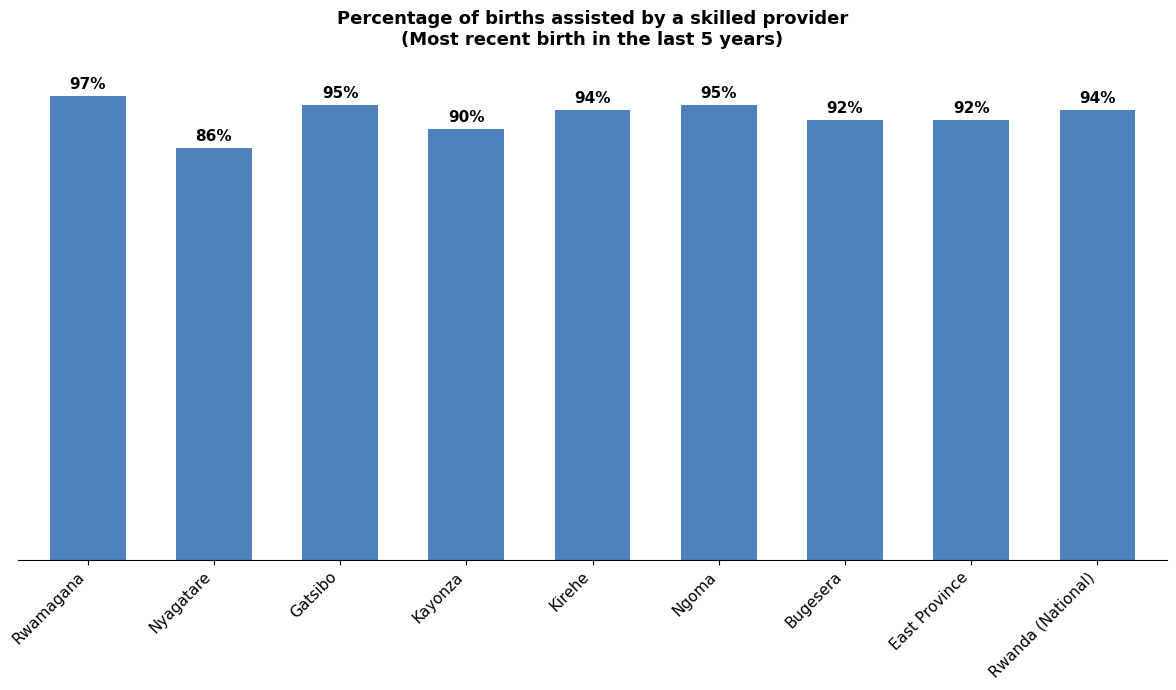

In [1]:
#!/usr/bin/env python3
# dhs_skilled_assistance_delivery.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 up, <0.5 down."""
    return int(math.floor(n + 0.5))

def get_skilled_pct(df):
    """Calculates weighted % of births assisted by a skilled provider."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    # Weighted average of the 'is_skilled' flag
    raw_pct = np.average(df['is_skilled'], weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Analyzing Assistance during Delivery)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ROBUST COLUMN PICKER ---
    # b3: Birth date of most recent child
    b3_col = next((c for c in df.columns if c in ['b3_01', 'b3_1', 'b3$01']), None)
    
    # Skilled assistance variables (Most recent birth index _1 or _01)
    # m3a: Doctor | m3b: Nurse/Midwife | m3c: Medical Assistant
    m3a = next((c for c in df.columns if c in ['m3a_1', 'm3a_01', 'm3a$01']), None)
    m3b = next((c for c in df.columns if c in ['m3b_1', 'm3b_01', 'm3b$01']), None)
    m3c = next((c for c in df.columns if c in ['m3c_1', 'm3c_01', 'm3c$01']), None)
    
    dist_col = next((c for c in ['sdistrict', 'sdstr', 'sdist', 'v001'] if c in df.columns), None)

    if not b3_col or not m3a:
        print("\n❌ Error: Critical columns (b3 or m3a) not found.")
        exit()

    print(f"✅ Found columns: Birth Date='{b3_col}', Assistance Vars='{m3a}, {m3b}, {m3c}'")

    # --- CREATE CLEAN WORKSET ---
    needed = [b3_col, m3a, m3b, m3c, 'v005', 'v008', 'v024', dist_col]
    work_df = df[needed].copy()

    # Convert to numeric
    for col in work_df.columns:
        work_df[col] = pd.to_numeric(work_df[col], errors='coerce').fillna(0)

    # Standardize names
    work_df['b_val'] = work_df[b3_col]
    work_df['w'] = work_df['v005'] / 1000000.0

    # --- FILTERS ---
    # Most recent birth in 5 years (60 months)
    work_df = work_df[(work_df['v008'] - work_df['b_val']) < 60].copy()
    
    # Define Skilled Provider Assistance (Code 1 = Yes)
    # Skilled if Doctor OR Nurse/Midwife OR Medical Assistant
    work_df['is_skilled'] = (
        (work_df[m3a] == 1) | 
        (work_df[m3b] == 1) | 
        (work_df[m3c] == 1)
    ).astype(int)

    # --- AGGREGATION ---
    results = {}
    df_east = work_df[work_df['v024'] == 5].copy()
    
    print(f"Analyzing {len(df_east)} births in the Eastern Province...")

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_skilled_pct(subset)

    # Totals
    results["East Province"] = get_skilled_pct(df_east)
    results["Rwanda (National)"] = get_skilled_pct(work_df)

    # Final DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Skilled Assistance %"]).set_index("Location")
    print("\n--- Summary Results: Skilled Assistance during Delivery % ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_skilled_assistance_delivery.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Skilled Assistance %"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    # Colors matching standard DHS report styles
    colors = ["#4F81BD"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 7), width=0.6, legend=False)
    
    plt.title("Percentage of births assisted by a skilled provider\n(Most recent birth in the last 5 years)", 
              fontsize=13, fontweight="bold", pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.xlabel("")
    
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Skilled_Assistance_Delivery.png", dpi=300)
    print(f"✅ Success! Analysis saved to {json_name}")